<h2>HUXt examples.</h2>

This notebook contains several examples of how to use the HUXt, as described in Owens et al (2020).

In [1]:
import numpy as np
import astropy.units as u
from astropy.time import Time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin

Run HUXt in 1D (along one longitude) with user specified V boundary conditions and no CMEs

In [ ]:
#Form longitudinal boundary conditions - background wind of 400 km/s with two fast streams.
v_boundary = np.ones(128) * 400 * (u.km/u.s)
v_boundary[30:50] = 600 * (u.km/u.s)
v_boundary[95:125] = 700 * (u.km/u.s)

# This boundary condition looks like
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(v_boundary,'k-')
ax.set_xlabel('Longitude bin')
ax.set_ylabel('Input Wind Speed (km/s)')
ax.set_xlim(0,128)

# Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step), looking at 0 longitude
model = H.HUXt(v_boundary=v_boundary, lon_out=0.0*u.deg, simtime=10*u.day, dt_scale=4)

# Solve these conditions, with no ConeCMEs added.
cme_list = []
model.solve(cme_list)

# Plot the radial profile of the ambient wind profile at a fixed time (in days). 
t = 1.5*u.day
HA.plot_radial(model, t, lon=0.0)

# Plot the time series of the ambient wind profile at a fixed radius. 
r = 1.0*u.AU
HA.plot_timeseries(model, r, lon=0.0)

Run HUXt in 1D (along one longitude) with user specified boundary conditions and single Cone CME

In [ ]:
# Set up a ConeCME that launches half a day after the simulation begins, at 0 longitude, 30 degree width, speed 850km/s and thickness=5 solar radii
cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=30*u.deg, v=850*(u.km/u.s), thickness=5*u.solRad)
cme_list = [cme]

# Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step), looking at 0 longitude
model = H.HUXt(v_boundary=v_boundary, lon_out=0.0*u.deg, simtime=5*u.day, dt_scale=4)

# Run the model, and this time save the results to file.
model.solve(cme_list, save=True, tag='1d_conecme_test')

# Plot the radial profile and time series of both the ambient and ConeCME solutions at a fixed time (in days). 
# Save both to file as well. These are saved in HUXt>figures>HUXt1D
t = 2*u.day
HA.plot_radial(model, t, lon=0.0*u.deg, save=True)

r = 1.0*u.AU
HA.plot_timeseries(model, r, lon=0.0*u.deg, tag='1d_cone_test_radial')

Now run HUXt using boundary conditions taken from HelioMAS output.

In [ ]:
#HUXt can be initiated MAS, by specifying a carrington rotation number
cr = 2054
vr_in = Hin.get_MAS_long_profile(cr, 0.0*u.deg)

model = H.HUXt(v_boundary=vr_in, cr_num=cr, lon_out=0.0*u.deg, simtime=27.27*u.day, dt_scale=4)

# Solve these conditions with a ConeCME.
cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=30*u.deg, v=1000*(u.km/u.s), thickness=10*u.solRad)
cme_list = [cme]
model.solve(cme_list)

# Plot the radial profile of the ambient wind solution at a fixed time (in days). 
t = 1.5*u.day
HA.plot_radial(model, t, lon=0.0*u.deg)

# Plot the time series of the ambient wind solution at a fixed radius. 
r = 1.0*u.AU
HA.plot_timeseries(model, r, lon=0.0*u.deg)


HUXt can also be run over multiple longitudes. Here HUXt is run over all longitudes, with user specified boundary conditions and a single CME

In [ ]:
#  Form boundary conditions - background wind of 400 km/s with two fast streams.
v_boundary = np.ones(128) * 400 * (u.km/u.s)
v_boundary[30:50] = 600 * (u.km/u.s)
v_boundary[95:125] = 700 * (u.km/u.s)

#  Add a CME
cme = H.ConeCME(t_launch=0.5*u.day, longitude=355*u.deg, width=30*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
cme_list = [cme]

#  Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step)
model = H.HUXt(v_boundary=v_boundary, simtime=5*u.day, dt_scale=4)

model.solve(cme_list)

# Plot this out
t_interest = 1.5*u.day
fig, ax = HA.plot(model, t_interest)

There is also a function to animate these data. They are saved in HUXt>Figures

In [ ]:
HA.animate(model, tag='cone_cme_test') # This takes about two minutes.

HUXt results can be saved to a HDF5 file, either automatically in the solve method, or by a separate save method. There is also a load function. 

In [ ]:
out_path = model.save(tag='cone_cme_test')
# And loaded back in with
model2, cme_list2 = H.load_HUXt_run(out_path)

CMEs are trackd through the HUXt domain using test particles that advect with the flow. These coordinates are accessible via the ConeCME objects.

In [ ]:
cme = model.cmes[0]
timestep = 50
r = cme.coords[timestep]['r'].to(u.solRad)
lon = cme.coords[timestep]['lon']
x = r * np.cos(lon)
y = r * np.sin(lon)

# There is also a "front_id" field to separate the nose and rear.
id_front = cme.coords[timestep]['front_id'] == 1.0
id_back = cme.coords[timestep]['front_id'] == 0.0

fig, ax = plt.subplots() # compare this with the boundary in the frame above.
ax.plot(x[id_front] , y[id_front] , 'r.')
ax.plot(x[id_back] , y[id_back] , 'kx')
ax.set_xlabel('X ($R_{sun}$)')
ax.set_ylabel('Y ($R_{sun}$)')

Multiple Cone CMEs can be inserted into HUXt in any run. Also, functions are provided to download inner boundary conditions from the HelioMAS model. Below we set up HUXt to run for Carrington rotation 2100, retrieving the boundary condition from Predictive Science (unless it is already downloaded). Then three Cone CMEs are inserted, and the output animated.

In [ ]:
#  Get inner boundary condition from Carrington rotation 2100
cr=2100
vr_in = Hin.get_MAS_long_profile(cr, 0.0*u.deg)
#  Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step).
model = H.HUXt(v_boundary=vr_in, cr_num=cr, simtime=5*u.day, dt_scale=4)

# Produce a list of ConeCMEs to pass to HUXt
daysec = 86400
times = [0.5*daysec, 1.5*daysec, 3*daysec]
speeds = [850, 1000, 700]
lons = [0, 90, 300]
widths = [30, 40, 20]
thickness = [5, 4, 2]
cme_list = []
for t, l, w, v, thick in zip(times, lons, widths, speeds, thickness):
    cme = H.ConeCME(t_launch=t*u.s, longitude=l*u.deg, width=w*u.deg, v=v*model.kms, thickness=thick*u.solRad)
    cme_list.append(cme)

model.solve(cme_list, save=True, tag='multi_cones') # This takes a minute or so to run. 
HA.plot(model, 3.5*u.day)
#HA.animate(model, tag='multi_cones')

There is also an ephemeris of the HEEQ, HAE, and Carrington coordiates of Earth, Mercury, Venus, STEREO-A and STEREO-B

In [ ]:
# These are automatically plotted on model solutions derived from a particular Carrington rotation.
HA.plot(model, model.time_out[0])

# You can retrieve a bodies position at each model timestep like:
earth = model.get_observer('earth')
sta = model.get_observer('sta')
venus = model.get_observer('venus')

# The bodies HEEQ and Carrington coordinates are attributes.
# So to plot them:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.plot(earth.lon, earth.r, 'co')
ax.plot(sta.lon, sta.r, 'rs')
ax.plot(venus.lon, venus.r, 'mo')

A function is provided to lookup the solar wind speed time series at Earth

In [ ]:
# Lookup Earth time series.
earth_series = HA.get_earth_timeseries(model)

# Plot this out and format the dates. 
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(earth_series['time'], earth_series['vsw'])
myFmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Date (mm-dd)')
ax.set_ylabel('Solar Wind Speed (km/s)')



HUXt can also be run over a limited range of longitudes. As HUXt is a purely radial model, it can be run over any set of longitudes. This could save disk-space and runtime if you are interested in large ensembles. This is done with the `lon_start` and `lon_stop` arguments.


In [ ]:
# Set up HUXt over a limited longitude range.
cr=2120
vr_in = Hin.get_MAS_long_profile(cr,0.0*u.deg)
model = H.HUXt(v_boundary=vr_in, cr_num=cr, lon_start=300*u.deg, lon_stop=60*u.deg, simtime=5*u.day, dt_scale=4)

# Get a list of two ConeCMEs
daysec = 86400
times = [0.5*daysec, 2*daysec]
speeds = [1000, 850]
lons = [-20, 20]
widths = [30, 30]
thickness = [8, 4]
cme_list = []
for t, l, w, v, thick in zip(times, lons, widths, speeds, thickness):
    cme = H.ConeCME(t_launch=t*u.s, longitude=l*u.deg, width=w*u.deg, v=v*model.kms, thickness=thick*u.solRad)
    cme_list.append(cme)

model.solve(cme_list, save=True, tag='multi_cones') 

t_interest = 1.5*u.day
HA.plot(model, t_interest)

The initial carrington longitude of Earth can be specified with the `cr_lon_init` argument. This sets the `time_init` attribute, so model times can be converted to UTC.

In [ ]:
cr=2120
vr_in = Hin.get_MAS_long_profile(cr,0.0*u.deg)

for cr_lon in [360, 270, 180]:
    model = H.HUXt(v_boundary=vr_in, cr_num=cr, cr_lon_init=cr_lon*u.deg, simtime=5*u.day, dt_scale=4)
    cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=60*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
    model.solve([cme])
    cr_tag = 'cr_lon_{:03d}'.format(np.int32(cr_lon))
    HA.plot(model, model.time_out[50], save=True, tag=cr_tag)
    print(model.cr_lon_init.to('deg'), model.time_init.isot)


HUXt can be run with two rerfernce frames - the inner boundary is rotated with either the mean sidreal rotation rate, or with the synodic rotation rate from Earth's perspective. This is set with the `frame` argument. This doesn't always have a large effect on the solution, but can be worth considering. For example, in highly structured solar wind it can affect the CME arrival time by a few hours. 

In [ ]:
cr=2120
vr_in = Hin.get_MAS_long_profile(cr,0.0*u.deg)

# Synodic
model = H.HUXt(v_boundary=vr_in, cr_num=cr, cr_lon_init=0*u.deg, simtime=5*u.day, dt_scale=4, frame='synodic')
cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=60*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
model.solve([cme])
fig, ax = HA.plot(model, model.time_out[100], save=True, tag='synodic')

# Sidereal
model = H.HUXt(v_boundary=vr_in, cr_num=cr, cr_lon_init=0*u.deg, simtime=5*u.day, dt_scale=4, frame='sidereal')
cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=60*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
model.solve([cme])
fig, ax = HA.plot(model, model.time_out[100], save=True, tag='sidereal')

A function is included to compute the arrival time of CMEs at the solar system bodies available in the Observer class - Mercury, Venus, Earth, STEREO-A and STEREO-B. We will use this to show how the different synoidc and sidereal frames can affect the CMEs arrival time. In this instance the CME is strongly affected by a high speed stream, and the CME arrival time at Earth is about 4 hours different for the synodic and sidereal frames. 

In [ ]:
cr=2056
vr_in = Hin.get_MAS_long_profile(cr, 0.0*u.deg)

#  Synodic
for frame in ['sidereal', 'synodic']:
    model = H.HUXt(v_boundary=vr_in, cr_num=cr, cr_lon_init=0*u.deg, simtime=5*u.day, dt_scale=4, frame=frame)
    cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=45*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
    model.solve([cme])
    cme = model.cmes[0]
    hit, t_arrive, t_transit, hit_lon, hit_id = cme.compute_arrival_at_body('EARTH')
    
    #  Plot the solution at the nearest time step to impact.
    HA.plot(model, model.time_out[hit_id])
    
    #  Print out some arrival stats
    print("**************************************")
    print("{}: Earth arrival:{},  Transit time:{:3.2f} days, Arrival longitude:{:3.2f}".format(frame, t_arrive.isot, t_transit, hit_lon))


Most of the model parameters are attributes of the HUXt class and so can be accessed like:

In [ ]:
# Model time step from the CFL condition:
print(model.dt)
# Output model time step
print(model.dt_out)
# A list of all attributes is in the documentation
help(model)

The inner boundary of HUXt defaults to 30Rs. But it can be specified by the user. To use the HelioMAS solutions with lower inner boundary heights, a function is provided to give an approximate mapping between the 30Rs solution and a lower specified height. Below, the 30Rs solution is mapped to 21.5Rs, the standard for Enlil, etc.

WARNING: It is not advisable to map solutions beyond around 5-10 rS, as the acceleration equation may not be valid. Also note that as results need to be interpolated onto a regular grid, mapped and unmapped solutions will not be identical.

In [ ]:
# Setup HUXt for a standard 30Rs run
cr = 2054
vr_in = Hin.get_MAS_long_profile(cr,0.0*u.deg)
#now run HUXt
model = H.HUXt(v_boundary=vr_in, cr_num=cr, latitude=0*u.deg,
               simtime=27*u.day, dt_scale=4, frame = 'sidereal')
model.solve([]) 

r = 30*u.solRad
HA.plot_timeseries(model, r, lon=0.0)

t_interest=3*u.day
HA.plot(model, t_interest)



#  Map the inner boundary MAS values inwards from 30 rS to 21.5 rS
vr_21rs = Hin.map_v_boundary_inwards(vr_in, 30*u.solRad, 21.5*u.solRad)

#  Now setup HUXt to run from 21.5Rs
model = H.HUXt(v_boundary = vr_21rs, cr_num=cr, simtime=27*u.day, 
               latitude=0*u.deg, dt_scale=4, r_min=21.5*u.solRad, frame = 'sidereal')
model.solve([])

r = 30*u.solRad
HA.plot_timeseries(model, r, lon=0.0)

t_interest=3*u.day
HA.plot(model, t_interest)


HUXt has post-processing support for tracing streamlines (equivalent to passive magnetic flux tubes) through a given velocity field

Files already exist for CR1938
Adjusting CME HEEQ longitude for sidereal frame


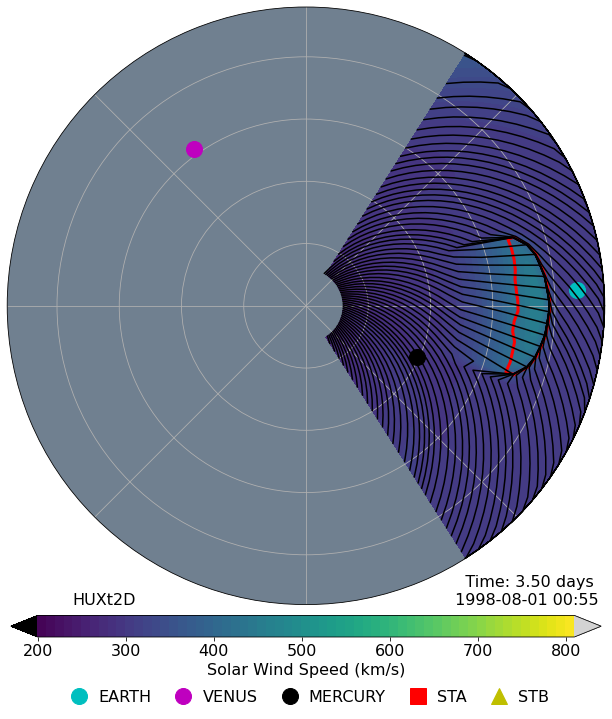

In [5]:
#for best results, save every HUXt time step (including spin up), using the "save_full_v" flag
cr = 1938
vr_in = Hin.get_MAS_long_profile(cr, 0.0*u.deg)
model = H.HUXt(v_boundary=vr_in, cr_num=cr, cr_lon_init = 50*u.deg, simtime=5*u.day, dt_scale=1, frame='sidereal',
               lon_start=300*u.deg, lon_stop=60*u.deg,
                save_full_v = True)
#add a CME
cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, width=40*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)
cme_list = [cme]
#solve
model.solve(cme_list)


#trace a bunch of field lines from a range of evenly spaced Carrington longitudes
Nlon = int(np.floor(np.pi*2/model.dlon.value))
dlon = model.dlon.value
lon_grid = np.arange(dlon/2, 2*np.pi-dlon/2 + 0.0001, dlon)*u.rad

field_lines = []   
for i in range(0, Nlon):
     r, l = HA.huxt_streamline(model, lon_grid[i])
     field_lines.append((r,l))

#plot these streamlines
time = 3.5*u.day
fig, ax = HA.plot(model,time)
id_t = np.argmin(np.abs(model.time_out - time))
for i in range(0, Nlon):
    r, lon = field_lines[i]
    ax.plot(lon, r[id_t, :], 'k') 

The HCS position can be tracked as a streamline and the associated B_polarity grid computed

Files already exist for CR1938


(<Figure size 720x720 with 2 Axes>, <PolarAxesSubplot:>)

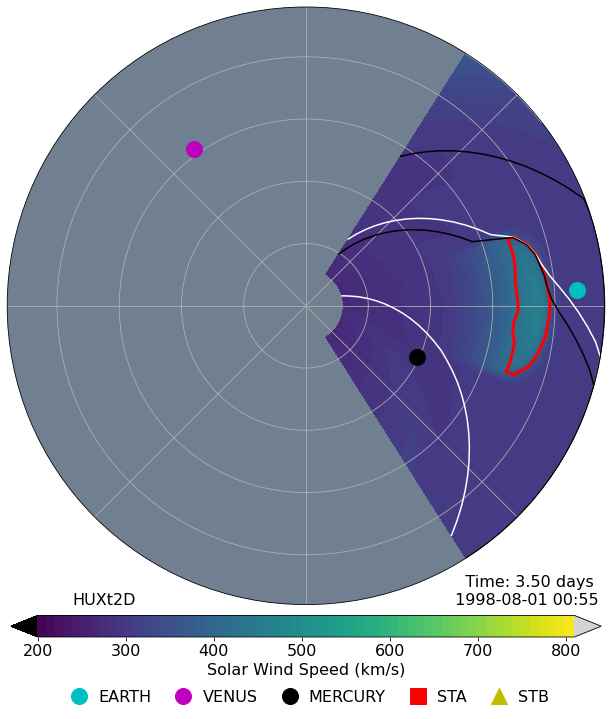

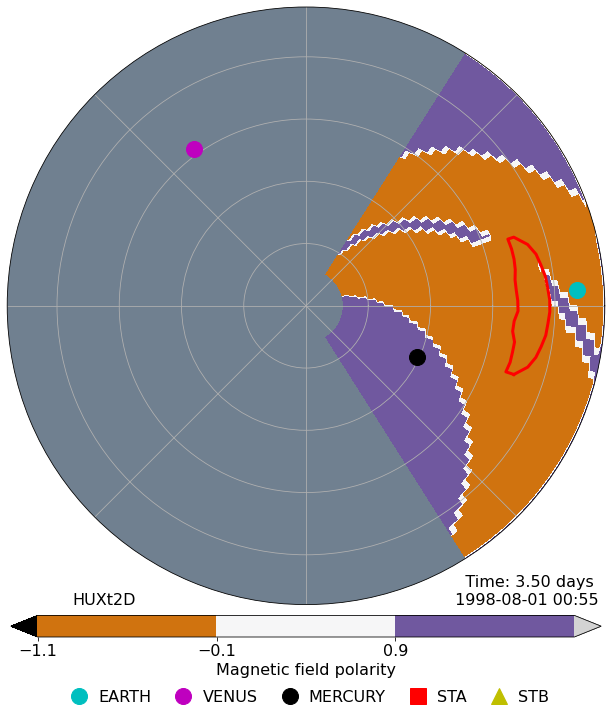

In [6]:
#get the Br values from the HelioMAS solution
br_in = Hin.get_MAS_br_long_profile(model.cr_num, 0.0*u.deg)  

#compute the HCS streamlines and the b_grid
HA.add_bgrid(model, br_in)

#plot the speed solution, including the HCS
time = 3.5*u.day
HA.plot_v_HCS(model, time)

#plot the b-polarity grid
HA.plot_bpol(model, time)

Extract and plot the timeseries at Earth

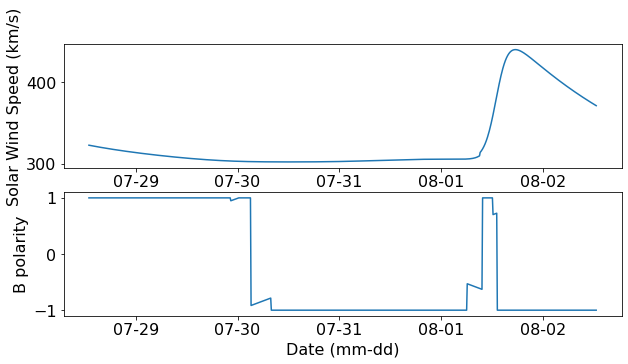

In [9]:
earth_series = HA.get_earth_timeseries(model)

# Plot this out and format the dates. 
fig, ax = plt.subplots(figsize=(10,5),nrows=2, ncols=1)
ax[0].plot(earth_series['time'], earth_series['vsw'])
ax[0].set_ylabel('Solar Wind Speed (km/s)')
ax[1].plot(earth_series['time'], earth_series['bpol'])
ax[1].set_ylabel('B polarity')

myFmt = mdates.DateFormatter('%m-%d')
for i in range(0,2):
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_xlabel('Date (mm-dd)')


The mp4 movie of the speed and HCS plot can be generated:

In [7]:
HA.animate_hcs(model, 'v_HCS')

Moviepy - Building video D:\Dropbox\python_repos\HUXt\figures\HUXt_CR1938_v_HCS_movie.mp4.
Moviepy - Writing video D:\Dropbox\python_repos\HUXt\figures\HUXt_CR1938_v_HCS_movie.mp4



Moviepy - Done !
Moviepy - video ready D:\Dropbox\python_repos\HUXt\figures\HUXt_CR1938_v_HCS_movie.mp4


There is some limited support for running HUXt in 3D. Currently this amounts to a wrapper class, `HUXt3D`, that computes the longitudinal solutions for a range of longitudes. 

In [ ]:
#set up a meridional cut run.
cr=2000
vmap, vlats, vlongs = Hin.get_MAS_vr_map(cr)

model3d=H.HUXt3d(cr_num=cr,v_map=vmap, v_map_lat=vlats, v_map_long=vlongs,
                    latitude_max=90*u.deg, latitude_min=-90*u.deg, lon_out=0.0*u.deg,
                    simtime=3*u.day, r_min=30*u.solRad)

cme = H.ConeCME(t_launch=0.5*u.day, longitude=0.0*u.deg, latitude=0.0*u.deg,
                width=30*u.deg, v=1000*(u.km/u.s), thickness=5*u.solRad)

#run the model
cme_list=[cme]
model3d.solve(cme_list)

#plot the meridional cut
HA.plot_3d_meridional(model3d, 2*u.day, lon=0*u.deg)

#animate the meridional cut
#HA.animate_3d(model3d, lon=0*u.deg, tag='model3d')
